<center><img src="img/mlflow.png" width="300" /></center>

In [1]:
import requests
import json
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'figure.figsize':(6,3), 'legend.loc':"best", 'lines.linewidth':1.5, 'lines.marker':".", "image.cmap":"tab10", 'axes.prop_cycle':plt.cycler(color=plt.cm.tab10.colors), 'axes.formatter.useoffset':False, 'axes.titlesize': 12,'axes.labelsize': 10,'ytick.labelsize':8,'xtick.labelsize':8,'legend.fontsize': 10})
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torchmetrics
import mlflow
from mlflow import MlflowClient

# Introduction

[MLflow](https://github.com/mlflow/mlflow), initially created at Databricks, is an open source platform, focusing on streamlining iterative machine learning development, including tracking and versioning experiments, packaging code into reproducible runs, and sharing and deploying scalable models. It is based on an open interface design and is able to work with any language, framework or platform, with clients in Python and Java. It offers a set of lightweight APIs that can be used with any existing machine learning application or library (like PyTorch or TensorFlow), wherever you currently run ML code (like notebooks, applications, or the cloud).

MLflow's current components are:
* [MLflow Tracking](https://mlflow.org/docs/latest/tracking.html): An API to log and query parameters, code, and results in machine learning experiments and compare them using an interactive UI.
* [MLflow Projects](https://mlflow.org/docs/latest/projects.html): A code packaging format for reproducible runs using Conda and Docker, so you can share your ML code with others.
* [MLflow Models](https://mlflow.org/docs/latest/models.html): A model packaging format and tools that let you easily deploy the same model (from any ML library) to batch and real-time scoring on platforms.
* [MLflow Model Registry](https://mlflow.org/docs/latest/model-registry.html): A centralized model store, set of APIs, and UI, to collaboratively manage the full lifecycle of MLflow Models.

# Installation

MLFlow can be installed through pip:
```bash
pip install mlflow
```

Once installed, it can be launched by running:
```bash
mlflow ui
```

The UI be accesed in you localhost on port 5000 ([http://127.0.0.1:5000](http://127.0.0.1:5000)).

# Demo

In what follows we will go through a toy example that demonstrates some of the key features of mlflow.

In [5]:
# Random seed for reproducibility
torch.manual_seed(42)

X_train: torch.Size([40, 1]) | X_test: torch.Size([10, 1]) | y_train: torch.Size([40, 1]) | y_test: torch.Size([10, 1]) 



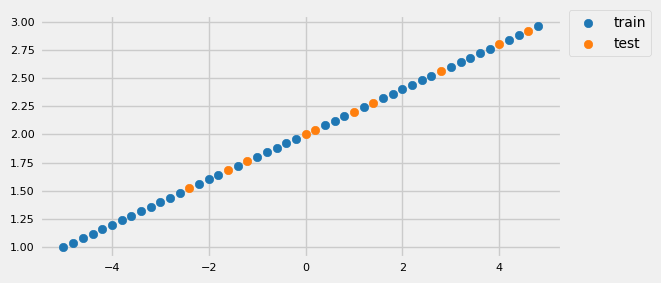

In [6]:
# Create data to experiment with
def make_data(plot=True):
    X = torch.arange(-5, 5, 0.2).unsqueeze(1)
    y = (lambda x: 0.2 * x + 2)(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"X_train: {X_train.shape} | X_test: {X_test.shape} | y_train: {y_train.shape} | y_test: {y_test.shape} \n")
        
    if plot:
        fig = plt.figure()
        plt.scatter(X_train, y_train, label='train')
        plt.scatter(X_test, y_test, label='test')
        plt.legend(bbox_to_anchor=(1,1.05), loc="upper left")
        plt.show()
    
    return X_train, X_test, y_train, y_test, fig

X_train, X_test, y_train, y_test, fig = make_data()

In [7]:
# Create model to experiment with
class LinearRegressionModel(nn.Module):
    
    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=in_features, out_features=out_features)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x.float())
    
model = LinearRegressionModel(in_features=X_train.shape[1], out_features=1)

## MLFlow Tracking

MLFlow Tracking is an API to log and query parameters, code, and results in machine learning experiments and compare them using an interactive UI. With MLflow Tracking we can track:
* **Parameters**: The parameters of the model in a key-value format.
* **Metrics**: The metrics of the model computed by the parameters.
* **Tags & Notes**: Information about a specific run.
* **Artifacts**: Things that you produce: files, data, and models.
* **Source**: Source code.
* **Version**: Github version of source code.

The two key concepts of MLFlow Tracking are **runs** and **experiments**.

**Run**: An instance of code that runs by MLflow.
>MLflow Tracking is organized around the concept of runs, which are executions of some piece of code. Each run records all the above mentioned metadata and artifacts.

**Experiment**: A set of different runs.
>An experiment groups together runs for a specific task. You can create an experiment using the CLI, API, or UI. The MLflow API and UI also let you create and search for experiments.

<center><img src="img/mlflow_tracking_architecture.png" width="700"/></center>

In [8]:
# Get the tracking directory path
mlflow.get_tracking_uri()

'mlruns'

In [9]:
# Set it to another directory
mlflow.set_tracking_uri('mlruns')

In [10]:
# Set experiment tracking
mlflow.set_experiment(experiment_name='tutorial')

2025/01/07 10:35:53 INFO mlflow.tracking.fluent: Experiment with name 'tutorial' does not exist. Creating a new experiment.


<Experiment: artifact_location='/Users/tasos/Repos/Personal/ml/03_mlflow/mlruns/739235878102147628', creation_time=1736242553815, experiment_id='739235878102147628', last_update_time=1736242553815, lifecycle_stage='active', name='tutorial', tags={}>

In [11]:
# Start run tracking
with mlflow.start_run(
    run_name = f"toy_model_run_{datetime.now().strftime('%Y-%m-%d-%H:%M:%S')}",
    tags={"version": "v1", "project": "tutorial", "run_month":{datetime.now().strftime('%Y-%m')}},
    description="Just a toy example"
):
    # Set loss function and log it
    loss_fn = nn.MSELoss()
    mlflow.log_param("loss", loss_fn.__class__.__name__)

    # Set optimizer and log hyperparameters
    optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)
    mlflow.log_params({
        "optimizer": optimizer.__class__.__name__,
        "lr": optimizer.param_groups[0]["lr"]
    })

    # Set an evaluation metric
    mse = torchmetrics.MeanSquaredError()

    # Set number of epochs and log them
    epochs = 200
    mlflow.log_param("epochs", epochs)

    # Pass data through model for a number of epochs
    for epoch in range(epochs): 

        # Train model
        model.train()
        y_pred = model(X_train)
        train_loss = loss_fn(y_pred, y_train)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        # Calculate and log training metric
        training_mse = mse(y_pred, y_train)
        mlflow.log_metric("training_mse", training_mse, step=epoch)
            
        # Validate model
        model.eval()
        with torch.inference_mode():
            y_pred = model(X_test)
            validation_loss = loss_fn(y_pred, y_test)
            
            # Calculate and log validation metric
            validation_mse = mse(y_pred, y_test)
            mlflow.log_metric("validation_mse", validation_mse, step=epoch)
        
        # Log train and validation loss
        mlflow.log_metrics({
            "train_loss": train_loss.item(),
            "validation_loss": validation_loss.item()
        }, step=epoch)

    # Log model
    mlflow.pytorch.log_model(model, "linear_model", registered_model_name="toy_model")

    # Log data plot
    mlflow.log_figure(fig, "dataset.png")

2025/01/07 10:36:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'toy_model'.
Created version '1' of model 'toy_model'.


## MLFlow Registry

The MLflow Model Registry is an integral component of the MLflow ecosystem, designed to streamline the management of machine learning models. It provides a centralized repository for model storage, versioning, and metadata annotation, facilitating collaboration and lifecycle management.

The Model Registry introduces a few concepts that describe and facilitate the full lifecycle of an MLflow Model.

**Model**
>An MLflow Model is created from an experiment or run that is logged with one of the model flavor’s `mlflow.<model_flavor>.log_model()` methods. Once logged, this model can then be registered with the Model Registry.

**Registered Model**
>An MLflow Model can be registered with the Model Registry. A registered model has a unique name, contains versions, aliases, tags, and other metadata.

**Model Version**
>Each registered model can have one or many versions. When a new model is added to the Model Registry, it is added as version 1. Each new model registered to the same model name increments the version number.

**Model Alias**
>Model aliases allow you to assign a mutable, named reference to a particular version of a registered model. By assigning an alias to a specific model version, you can use the alias to refer that model version via a model URI or the model registry API. Aliases are especially useful for deploying models.

**Tags**
>Tags are key-value pairs that you associate with registered models and model versions, allowing you to label and categorize them by function or status.

**Annotations and Descriptions**
>You can annotate the top-level model and each version individually using Markdown, including description and any relevant information useful for the team such as algorithm descriptions, dataset employed or methodology.

<center><img src="img/mlflow_registry_architecture.png" width="1000"/></center>

### Register Model To Registry

In [21]:
# Register model during logging (DO IT WITHIN A RUN)
# mlflow.pytorch.log_model(model, "linear_model", registered_model_name="toy_model")

In [12]:
# Add extra details to a model
client = MlflowClient()

# Add a description to the registered model
client.update_registered_model(
    name="toy_model",
    description="The toy model for the tutorial project."
)

# Set registered model tag
client.set_registered_model_tag("toy_model", "stage", "production")

### Load Model From Registry As Standalone

The simplest and most straight forward way to load the model from registry, is to access it through its URI which is of the form:

```
models:/<model_name>/<version>
```

and treat it as a usual model.

In [15]:
# Load model from Model Registry
loaded_model = mlflow.pytorch.load_model("models:/toy_model/1")

In [16]:
# Make predictions
loaded_model(X_test)

tensor([[1.5008],
        [2.5360],
        [2.1777],
        [2.7749],
        [1.6601],
        [2.8944],
        [2.0184],
        [1.9786],
        [2.2573],
        [1.7397]], grad_fn=<AddmmBackward0>)

### Load Model From Registry As Inference Server

A second option is to deploy an MLFlow Inference Server where one can interact with the model through API calls. To do so, one has to serve the model through `mlflow` using:

```
mlflow models serve -m models:/<model_name>/<version> -p <port> --no-conda
```

where `models:/<model_name>/<version>` specifies the model in use and `<port>` the port we want the API to be exposed.

The inference server provides 4 endpoints:
* `/invocations`: An inference endpoint that accepts POST requests with input data and returns predictions.
* `/ping`: Used for health checks.
* `/health`: Same as /ping.
* `/version`: Returns the MLflow version.

In [12]:
# Prepare the input data for the model
input_data = json.dumps(
    {"inputs": X_test.tolist()}
)

# Send the POST request
response = requests.post(
    url="http://127.0.0.1:5001/invocations", 
    data=input_data,
    headers={"Content-Type": "application/json"}
)

# Parse response
print(response.json())

{'predictions': [[1.5008416175842285], [2.5360467433929443], [2.177706480026245], [2.774940252304077], [1.6601040363311768], [2.8943867683410645], [2.018444299697876], [1.9786286354064941], [2.2573375701904297], [1.7397351264953613]]}
